
# ANN for Hydrochar Carbon Mass

This is the **Artificial Neural Network (ANN)** part to predict **Hydrochar carbon mass (g)**
from hydrothermal carbonization (HTC) experiment parameters. I use excel file
**`sample_htc_data.xlsx`** (sheet: **Hydrothermal carbonization**).

**What I do here:**
1. Load and preview data  
2. Preprocess (clean, scale)  
3. Train ANN (`MLPRegressor`)  
4. Evaluate (MAE, RMSE, R²) + Actual vs Predicted plot  
5. Correlation heatmap (test fold)  
6. SHAP feature importance  
7. Create **`new_data_for_prediction.xlsx`** automatically  
8. Predict on the new data and review results  



In [1]:

# Step 1 — Imports & setup
import os, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor

# Optional (SHAP for explainability). If missing, I need to install in a new cell: !pip install shap
import shap

plt.rcParams["font.sans-serif"] = ["Times New Roman"]

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\check\OneDrive - Kentucky State University\Python Learning\New folder


In [2]:

# Step 2 — Load my Excel data
def get_data(file_path, sheet_name="Hydrothermal carbonization"):
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    # Replace NaNs with 0 (I can change to median imputation later)
    data = data.replace([np.nan], 0)
    return data

# My uploaded file name (It already in the same folder for this notebook run)
data_path = "sample_htc_data.xlsx"  # I will change if I use a different file name
data = get_data(data_path)
print("Rows, columns:", data.shape)
display(data.head(10))


Rows, columns: (292, 17)


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Hydrochar carbon mass g,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,0.0,20.0,50.0,0.066407,0.0,0.0,30.336667,0.0,0.0,Two-step hydrothermal conversion of biomass wa...
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,1.0,20.0,50.0,0.066239,0.0,0.0,30.260000,0.0,0.0,0
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4.0,1.0,20.0,50.0,0.091726,0.0,0.0,41.903333,0.0,0.0,0
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4.0,1.0,20.0,50.0,0.067498,0.0,0.0,30.835000,0.0,0.0,0
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.022480,0.0,0.0,11.240000,0.0,0.0,Hydrothermal humification of lignocellulosic c...
5,Hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.026528,0.0,0.0,13.264000,0.0,0.0,0
6,Cellulose+hemicellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.042844,0.0,0.0,21.422222,0.0,0.0,0
7,Cellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.009910,0.0,0.0,4.955000,0.0,0.0,0
8,Hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.019300,0.0,0.0,9.650000,0.0,0.0,0
9,Cellulose+hemicellulose+lignin,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.015000,0.0,0.0,7.500000,0.0,0.0,0


In [3]:

# Step 3 — Preprocess (select columns, numeric coercion, scale, split)
def preprocess_data(data):
    col_cond = [
        "mass g",
        "Vessel volume ml",
        "Carbon content %",
        "Hydrogen content %",
        "Oxygen content %",
        "Reaction temperature",
        "Hold time h",
        "pH",
        "Liquid-to-solid ratio",
    ]
    col_res = ["Hydrochar carbon mass g"]

    # Ensure required columns exist
    for col in col_cond + col_res:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")

    # Convert to numeric (coerce errors to NaN)
    for col in col_cond + col_res:
        data[col] = pd.to_numeric(data[col], errors="coerce")

    # Replace inf with NaN, then fill NaN with median (numeric only)
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.fillna(data.median(numeric_only=True))

    original_data = data.copy()

    # Scale inputs
    scaler = StandardScaler()
    data[col_cond] = scaler.fit_transform(data[col_cond])

    X = data[col_cond].values
    y = data[col_res].values.flatten()

    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
        X, y, data.index, test_size=0.2, random_state=42
    )

    return (
        X_train, X_test, y_train, y_test,
        train_idx, test_idx, data[col_cond].columns, original_data, scaler
    )

X_train, X_test, y_train, y_test, train_idx, test_idx, feature_names, original_data, scaler = preprocess_data(data)
print("Train size:", len(X_train), "Test size:", len(X_test))
feature_names


Train size: 233 Test size: 59


Index(['mass g', 'Vessel volume ml', 'Carbon content %', 'Hydrogen content %',
       'Oxygen content %', 'Reaction temperature', 'Hold time h', 'pH',
       'Liquid-to-solid ratio'],
      dtype='object')

In [4]:

# Step 4 — Build & train ANN
def build_model():
    return MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=1000,
        random_state=30,
        activation='relu',
        solver='adam'
    )

model = build_model()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R^2  = {r2:.3f}")


MAE  = 0.469
RMSE = 0.735
R^2  = 0.967


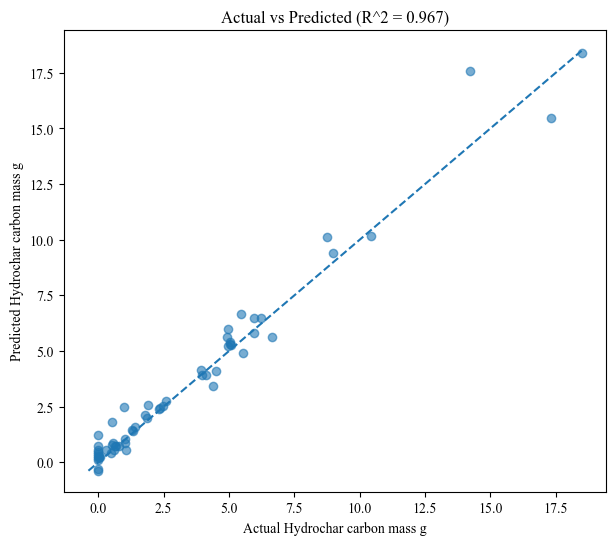

In [5]:

# Step 5 — Actual vs Predicted plot
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
lo = min(min(y_test), min(y_pred))
hi = max(max(y_test), max(y_pred))
plt.plot([lo, hi], [lo, hi], linestyle="--")
plt.xlabel("Actual Hydrochar carbon mass g")
plt.ylabel("Predicted Hydrochar carbon mass g")
plt.title(f"Actual vs Predicted (R^2 = {r2:.3f})")
plt.show()


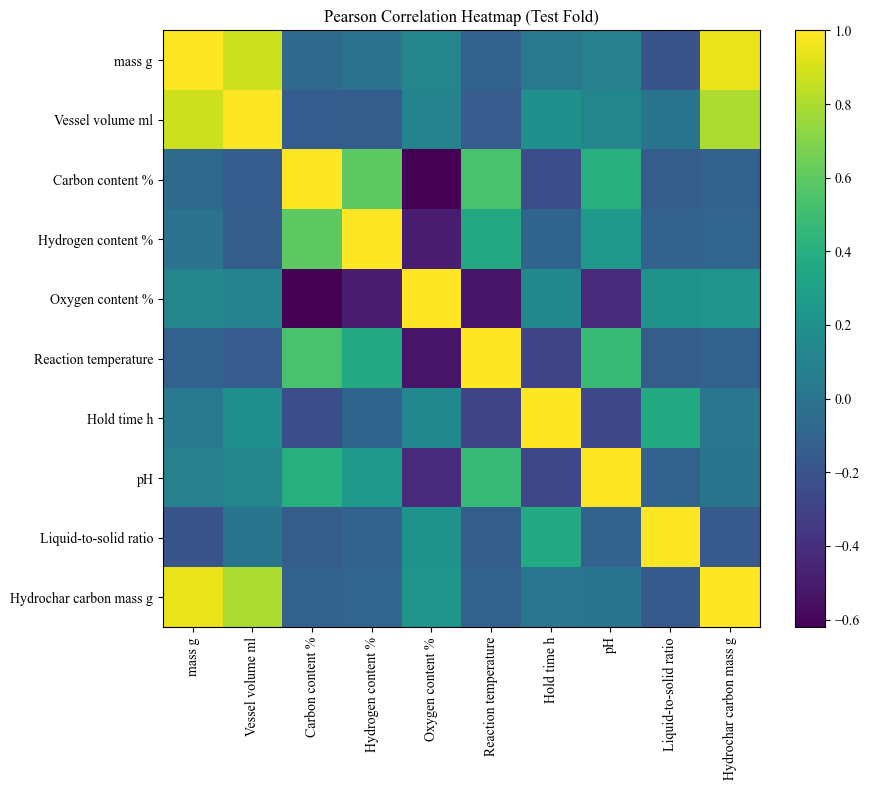

In [6]:

# Step 6 — Correlation heatmap (test fold) with matplotlib
test_df = original_data.loc[test_idx].copy()
test_df["Predicted Hydrochar carbon mass g"] = model.predict(
    scaler.transform(test_df[feature_names])
)

corr_cols = feature_names.tolist() + ["Hydrochar carbon mass g"]
corr = test_df[corr_cols].corr(method='pearson')

plt.figure(figsize=(10,8))
im = plt.imshow(corr, interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Pearson Correlation Heatmap (Test Fold)")
plt.tight_layout()
plt.show()


  0%|          | 0/30 [00:00<?, ?it/s]

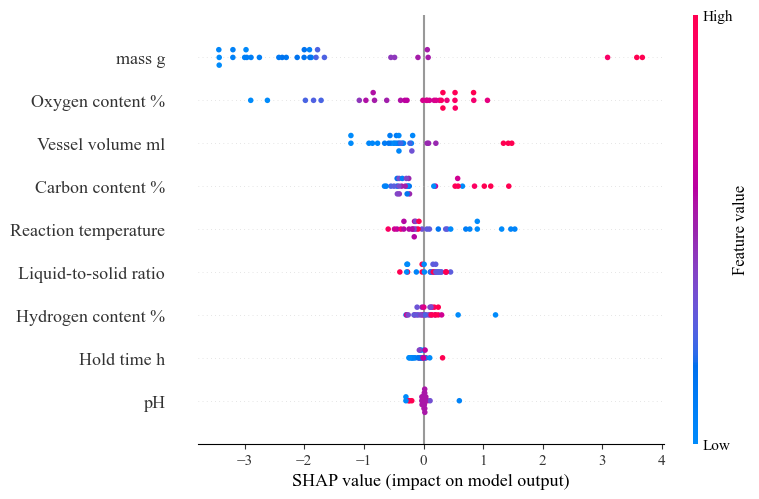

In [7]:

# Step 7 — SHAP summary (may take a bit; I will reduce sizes if slow)
try:
    X_background = X_train[:40] if X_train.shape[0] > 40 else X_train
    X_explain = X_test[:30] if X_test.shape[0] > 30 else X_test

    explainer = shap.KernelExplainer(model.predict, X_background)
    shap_values = explainer.shap_values(X_explain)

    shap.summary_plot(shap_values, X_explain, feature_names=feature_names)
except Exception as e:
    print("SHAP skipped due to:", e)


In [8]:

# Step 8 — now Creating 'new_data_for_prediction.xlsx' automatically from my data
target_col = "Hydrochar carbon mass g"
input_cols = [c for c in data.columns if c != target_col]

new_data = data[input_cols].head(5).copy()
new_file = "new_data_for_prediction.xlsx"
new_data.to_excel(new_file, index=False)

print("Created:", os.path.abspath(new_file))
display(new_data)


Created: C:\Users\check\OneDrive - Kentucky State University\Python Learning\New folder\new_data_for_prediction.xlsx


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,0.0,20.0,50.0,0.0,0.0,30.336667,0.0,0.0,Two-step hydrothermal conversion of biomass wa...
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4.0,1.0,20.0,50.0,0.0,0.0,30.260000,0.0,0.0,0
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4.0,1.0,20.0,50.0,0.0,0.0,41.903333,0.0,0.0,0
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4.0,1.0,20.0,50.0,0.0,0.0,30.835000,0.0,0.0,0
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4.0,1.0,20.0,50.0,0.0,0.0,11.240000,0.0,0.0,Hydrothermal humification of lignocellulosic c...


In [9]:

# Step 9 — Load new data and predict
new_df = pd.read_excel("new_data_for_prediction.xlsx")
X_new = scaler.transform(new_df[feature_names])
new_df["Predicted Hydrochar carbon mass g"] = model.predict(X_new)

print("Preview of predictions:")
display(new_df.head())

# Optionally save results
out_pred = "ANNHC_predictions.xlsx"
new_df.to_excel(out_pred, index=False)
print("Saved predictions to:", os.path.abspath(out_pred))


Preview of predictions:


,Type,mass g,Carbon content %,Hydrogen content %,Oxygen content %,Reaction temperature,Hold time h,pH,Liquid-to-solid ratio,Vessel volume ml,Aqueous phase carbon mass g,Oli phase carbon mass g,Hydrochar carbon yield %,Aqueous phase carbon yield %,Oli phase carbon yield %,References,Predicted Hydrochar carbon mass g
0,Corn stalk,0.5,43.78,5.720000,50.060000,180,4,0,20,50,0,0,30.336667,0,0,Two-step hydrothermal conversion of biomass wa...,0.133735
1,Corn stalk,0.5,43.78,5.720000,50.060000,180,4,1,20,50,0,0,30.260000,0,0,0,0.135238
2,Corn stalk,0.5,43.78,5.720000,50.060000,160,4,1,20,50,0,0,41.903333,0,0,0,0.483536
3,Corn stalk,0.5,43.78,5.720000,50.060000,200,4,1,20,50,0,0,30.835000,0,0,0,0.012483
4,Cellulose,0.5,40.00,6.666667,53.333333,180,4,1,20,50,0,0,11.240000,0,0,Hydrothermal humification of lignocellulosic c...,0.217594


Saved predictions to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\New folder\ANNHC_predictions.xlsx


In [10]:

# Step 10 — Save metrics & test report (optional)
results = pd.DataFrame({
    "MAE": [mae],
    "RMSE": [rmse],
    "R2": [r2],
    "Timestamp": [datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")]
})
results_file = "ANNHC_results.xlsx"
results.to_excel(results_file, index=False)
print("Saved metrics to:", os.path.abspath(results_file))

test_report = test_df.copy()
test_report_file = "ANNHC_test_report.xlsx"
test_report.to_excel(test_report_file, index=False)
print("Saved test report to:", os.path.abspath(test_report_file))


Saved metrics to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\New folder\ANNHC_results.xlsx
Saved test report to: C:\Users\check\OneDrive - Kentucky State University\Python Learning\New folder\ANNHC_test_report.xlsx
